#### Merge Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

#File path
excel_file_path = 'Excel_files/Task_Data_Scientist_Dataset.xlsx'

# Make excel sheets into dataframes
df_sheet2 = pd.read_excel(excel_file_path, sheet_name='Soc_Dem')
df_sheet3 = pd.read_excel(excel_file_path, sheet_name='Products_ActBalance')
df_sheet4 = pd.read_excel(excel_file_path, sheet_name='Inflow_Outflow')
df_sheet5 = pd.read_excel(excel_file_path, sheet_name='Sales_Revenues')

# Merging the Dataframes based on the column 'Client'
df = pd.merge(df_sheet2, df_sheet3, on='Client', how='outer')
df = pd.merge(df, df_sheet4, on='Client', how='outer')

# Distinguish the full merged dataset and the individual one accounting for 60%
df_merge = pd.merge(df, df_sheet5, on='Client', how='outer')

display(df_merge.shape)
display(df_merge.head())

(1615, 36)

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,909,M,21,27,1,NaN,NaN,1.0,NaN,1.0,...,7.0,1.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1217,M,38,165,1,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,850,F,49,44,1,NaN,NaN,NaN,NaN,NaN,...,6.0,0.0,0.0,1.0,0.0,1.0,0.0,0.000000,0.893929,0.0
3,1473,M,54,34,1,1.0,NaN,NaN,1.0,1.0,...,38.0,1.0,26.0,11.0,1.0,0.0,0.0,4.929643,0.000000,0.0
4,1038,M,29,106,1,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [2]:
duplicate_rows = df_merge.duplicated().sum()

print('Total number of duplicate rows:',duplicate_rows)

Total number of duplicate rows: 0


In [3]:
# Create dummy variables for Sex
sex_mapping = {'M': 1, 'F': 0}
df_merge['Sex'] = df_merge['Sex'].replace(sex_mapping)

In [4]:
# Replace missing values with 0
df_merge = df_merge.replace(np.nan,0)

In [5]:
# Create Merged excel file

current_directory = os.getcwd()
output_folder_path = 'Excel_files'

# Generating a new excel file with the corresponding excel folder
output_excel_path = os.path.join(output_folder_path, 'Merged_dataset.xlsx')

df_merge.to_excel(output_excel_path, index=False)

#### Exploratory Data Analysis

##### Client Age

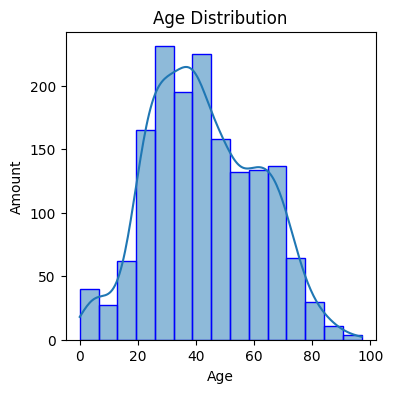

In [6]:
# Review the age distribution

plt.figure(figsize=(4, 4))

sns.histplot(df_merge['Age'], bins=15, edgecolor="b", kde=True)

plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Amount')

plt.show()


There seem to be ages that are quite young for holding accounts at the bank. Hence, I can assume that these values are erroneous.
Here, I will verify how many clients are younger than 10 years old (min. age account opening in Belgium). 
Moreover, I will verify whether there are irregularities of 'Tenure' being larger than the actual age of a client as well.

In [7]:
# Verify the rows where Age is less than 10 years old

age_threshold = df_merge['Age'] < 10
print("Underage clients:", age_threshold.sum())

Underage clients: 51


In [8]:
# Verify when Tenure in years is larger than Age

anomaly_tenure = df_merge['Tenure']/12 > df_merge['Age']

print("Number of anomalies:", anomaly_tenure.sum())

Number of anomalies: 47


##### Gender

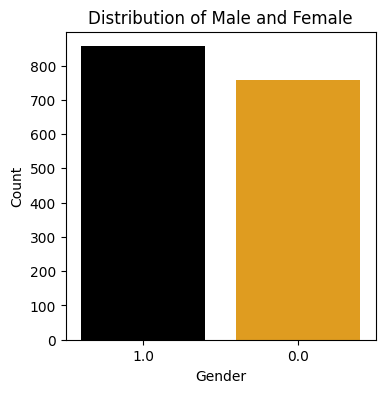

In [9]:
warnings.filterwarnings("ignore")

df_merge['Sex'] = df_merge['Sex'].astype(str)

plt.figure(figsize=(4, 4))


sns.countplot(x='Sex', data=df_merge, palette={'0.0': 'orange', '1.0': 'black'})

plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of Male and Female')
plt.show()

##### Sales Revenue

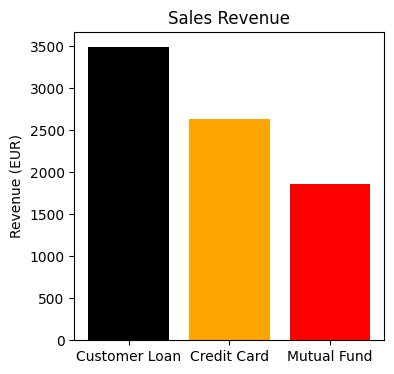

In [10]:
plt.figure(figsize=(4,4))

columns = np.arange(3)
revenue = [df_merge['Revenue_CL'].sum(), df_merge['Revenue_CC'].sum(), df_merge['Revenue_MF'].sum()]

plt.bar(columns, revenue, align='center', color=["black","orange","red"])
plt.xticks(columns, ['Customer Loan','Credit Card','Mutual Fund'])
plt.ylabel('Revenue (EUR)')
plt.title('Sales Revenue')
plt.show()

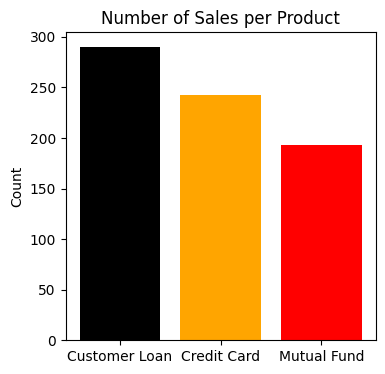

In [11]:
plt.figure(figsize=(4,4))

columns = np.arange(3)
revenue = [df_merge['Sale_CL'].sum(), df_merge['Sale_CC'].sum(), df_merge['Sale_MF'].sum()]

plt.bar(columns, revenue, align='center', color=["black","orange","red"])
plt.xticks(columns, ['Customer Loan','Credit Card','Mutual Fund'])
plt.ylabel('Count')
plt.title('Number of Sales per Product')
plt.show()

#### Training Set per Product

##### Data Cleaning

In [12]:
# 60% conveying training set, hence excluding df_merge
df_train = pd.merge(df, df_sheet5, on='Client', how='inner')

display(df_train.shape)
display(df_train.head())

(969, 36)

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1217,M,38,165,1,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,1.0,0,0,0,0.000000,0.000000,0.000000
1,850,F,49,44,1,NaN,NaN,NaN,NaN,NaN,...,6.0,0.0,0.0,1.0,0,1,0,0.000000,0.893929,0.000000
2,1473,M,54,34,1,1.0,NaN,NaN,1.0,1.0,...,38.0,1.0,26.0,11.0,1,0,0,4.929643,0.000000,0.000000
3,1038,M,29,106,1,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0,0,0,0.000000,0.000000,0.000000
4,225,M,14,187,1,NaN,NaN,1.0,NaN,NaN,...,5.0,0.0,4.0,1.0,0,0,1,0.000000,0.000000,8.130714


In [13]:
# Replace M/F with dummy variables
df_train['Sex'] = df_train['Sex'].replace(sex_mapping)

In [14]:
missing_value_sex= df_train['Sex'].isnull().sum()
display(missing_value_sex)

# Replace missing values with 0
df_train = df_train.replace(np.nan,0)

2

In [27]:
# Replacing ages younger than 10 with the median

median_age = df_train['Age'].median()
df_train.loc[df_train['Age'] < 10, 'Age'] = median_age


In [29]:
# 

age_threshold_train = df_train['Age'] < 10
print("Underage clients:", age_threshold_train.sum())

anomaly_tenure_train = df_train['Tenure']/12 > df_train['Age']
print("Number of anomalies:", anomaly_tenure_train.sum())

Underage clients: 0
Number of anomalies: 9


In [28]:
df_train.head()

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1217,1.0,38,165,1,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0,0,0,0.000000,0.000000,0.000000
1,850,0.0,49,44,1,0.0,0.0,0.0,0.0,0.0,...,6.0,0.0,0.0,1.0,0,1,0,0.000000,0.893929,0.000000
2,1473,1.0,54,34,1,1.0,0.0,0.0,1.0,1.0,...,38.0,1.0,26.0,11.0,1,0,0,4.929643,0.000000,0.000000
3,1038,1.0,29,106,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0.000000,0.000000,0.000000
4,225,1.0,14,187,1,0.0,0.0,1.0,0.0,0.0,...,5.0,0.0,4.0,1.0,0,0,1,0.000000,0.000000,8.130714


In [18]:
# Create full training set for consumer loan
consumer_loan = ['Sale_MF','Sale_CC','Revenue_MF','Revenue_CC','Count_CL','ActBal_CL']
df_train_cl = df_train.drop(consumer_loan,axis=1)

# Create full training set for credit card
credit_card = ['Sale_MF','Sale_CL','Revenue_MF','Revenue_CL','Count_CC','ActBal_CC']
df_train_cc  = df_train.drop(credit_card,axis=1)

# Create full training set for mutual fund
mutual_fund = ['Sale_CC','Sale_CL','Revenue_CC','Revenue_CL','Count_MF','ActBal_MF']
df_train_mf = df_train.drop(mutual_fund,axis=1)

In [19]:
print(df_train_cl.shape)

print(df_train_cc.shape)

print(df_train_mf.shape)

(969, 30)
(969, 30)
(969, 30)


### Types

In [20]:
df_train_cl[df_train_cl.columns[:18]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 969 entries, 0 to 968
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Client               969 non-null    int64  
 1   Sex                  969 non-null    float64
 2   Age                  969 non-null    int64  
 3   Tenure               969 non-null    int64  
 4   Count_CA             969 non-null    int64  
 5   Count_SA             969 non-null    float64
 6   Count_MF             969 non-null    float64
 7   Count_OVD            969 non-null    float64
 8   Count_CC             969 non-null    float64
 9   ActBal_CA            969 non-null    float64
 10  ActBal_SA            969 non-null    float64
 11  ActBal_MF            969 non-null    float64
 12  ActBal_OVD           969 non-null    float64
 13  ActBal_CC            969 non-null    float64
 14  VolumeCred           969 non-null    float64
 15  VolumeCred_CA        969 non-null    flo

In [21]:
df_train_cl[df_train_cl.columns[18:]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 969 entries, 0 to 968
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   VolumeDeb                     969 non-null    float64
 1   VolumeDeb_CA                  969 non-null    float64
 2   VolumeDebCash_Card            969 non-null    float64
 3   VolumeDebCashless_Card        969 non-null    float64
 4   VolumeDeb_PaymentOrder        969 non-null    float64
 5   TransactionsDeb               969 non-null    float64
 6   TransactionsDeb_CA            969 non-null    float64
 7   TransactionsDebCash_Card      969 non-null    float64
 8   TransactionsDebCashless_Card  969 non-null    float64
 9   TransactionsDeb_PaymentOrder  969 non-null    float64
 10  Sale_CL                       969 non-null    int64  
 11  Revenue_CL                    969 non-null    float64
dtypes: float64(11), int64(1)
memory usage: 91.0 KB


### Dummy Variable

In [22]:
# Numerical features
numerical_features = df_train_cl.select_dtypes(include=['number']).columns.tolist()

# Categorical features
categorical_features = df_train_cl.select_dtypes(include=['object']).columns.tolist()


print("Numerical Features:\n",numerical_features)
print("Categorical Features:\n",categorical_features)

Numerical Features:
 ['Client', 'Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'VolumeCred', 'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder', 'Sale_CL', 'Revenue_CL']
Categorical Features:
 []


In [23]:
# Create dummy variables for Sex
sex_mapping = {'M': 1, 'F': 0}
df_train_cl['Sex'] = df_train_cl['Sex'].replace(sex_mapping)

In [24]:
df_train_cl.head()

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,ActBal_CA,...,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_CL,Revenue_CL
0,1217,1.0,38,165,1,0.0,0.0,0.0,0.0,6752.244643,...,0.000000,0.000000,714.285714,1.0,1.0,0.0,0.0,1.0,0,0.000000
1,850,0.0,49,44,1,0.0,0.0,0.0,0.0,43.523214,...,0.000000,0.000000,121.928571,6.0,6.0,0.0,0.0,1.0,0,0.000000
2,1473,1.0,54,34,1,1.0,0.0,0.0,1.0,29.024286,...,357.142857,444.597500,2076.785714,48.0,38.0,1.0,26.0,11.0,0,0.000000
3,1038,1.0,29,106,1,0.0,0.0,0.0,0.0,27.035714,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0,0.000000
4,225,1.0,14,187,1,0.0,0.0,1.0,0.0,345.686071,...,0.000000,111.235714,19.285714,5.0,5.0,0.0,4.0,1.0,1,8.130714


### Missing Values

In [25]:
percent_missing = round(df_train_cl.isnull().sum() * 100 / len(df),2)
missing_value_df = pd.DataFrame({'Missing_Percentage': percent_missing})
missing_value_df.sort_values(by="Missing_Percentage",ascending=False)

,Missing_Percentage
Client,0.0
Sex,0.0
Sale_CL,0.0
TransactionsDeb_PaymentOrder,0.0
TransactionsDebCashless_Card,0.0
TransactionsDebCash_Card,0.0
TransactionsDeb_CA,0.0
TransactionsDeb,0.0
VolumeDeb_PaymentOrder,0.0
VolumeDebCashless_Card,0.0


In [26]:
# checking for null values in the data set
col = df_train_cl.columns
for i in col:
    # count number of rows with missing values
    n_miss = df_train_cl[[i]].isnull().sum()
    perc = n_miss / df_train_cl.shape[0] * 100
    print('%s, Missing: %d (%.1f%%)' % (i, n_miss, perc))

Client, Missing: 0 (0.0%)
Sex, Missing: 0 (0.0%)
Age, Missing: 0 (0.0%)
Tenure, Missing: 0 (0.0%)
Count_CA, Missing: 0 (0.0%)
Count_SA, Missing: 0 (0.0%)
Count_MF, Missing: 0 (0.0%)
Count_OVD, Missing: 0 (0.0%)
Count_CC, Missing: 0 (0.0%)
ActBal_CA, Missing: 0 (0.0%)
ActBal_SA, Missing: 0 (0.0%)
ActBal_MF, Missing: 0 (0.0%)
ActBal_OVD, Missing: 0 (0.0%)
ActBal_CC, Missing: 0 (0.0%)
VolumeCred, Missing: 0 (0.0%)
VolumeCred_CA, Missing: 0 (0.0%)
TransactionsCred, Missing: 0 (0.0%)
TransactionsCred_CA, Missing: 0 (0.0%)
VolumeDeb, Missing: 0 (0.0%)
VolumeDeb_CA, Missing: 0 (0.0%)
VolumeDebCash_Card, Missing: 0 (0.0%)
VolumeDebCashless_Card, Missing: 0 (0.0%)
VolumeDeb_PaymentOrder, Missing: 0 (0.0%)
TransactionsDeb, Missing: 0 (0.0%)
TransactionsDeb_CA, Missing: 0 (0.0%)
TransactionsDebCash_Card, Missing: 0 (0.0%)
TransactionsDebCashless_Card, Missing: 0 (0.0%)
TransactionsDeb_PaymentOrder, Missing: 0 (0.0%)
Sale_CL, Missing: 0 (0.0%)
Revenue_CL, Missing: 0 (0.0%)
